In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## K-Means Clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Academics/2 - Winter 2025/32024 - Algorithmic Marketing/Algorithmic Marketing Group 6/Final Project/Dataset/Merged Songs.csv')

In [ ]:
df['WeekID'] = pd.to_datetime(df['WeekID'])

df = df.drop(columns=['url', 'Instance', 'index_y', 'SongID_y', 'spotify_track_id', 'spotify_track_preview_url', 'spotify_track_explicit', 'spotify_track_album'])

#df_cleaned = df_cleaned = df.sort_values(by=['WeekID', 'Week Position']).drop_duplicates(subset=['WeekID', 'SongID_x'], keep='first')
#df_cleaned = df_cleaned.groupby('WeekID').head(100).reset_index(drop=True)

features = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo'
]

df_clustering = df[features].dropna()

In [ ]:
# Standardizing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clustering)

#### Reduce Dimensions by Removing Autocorrelated Features before Clustering

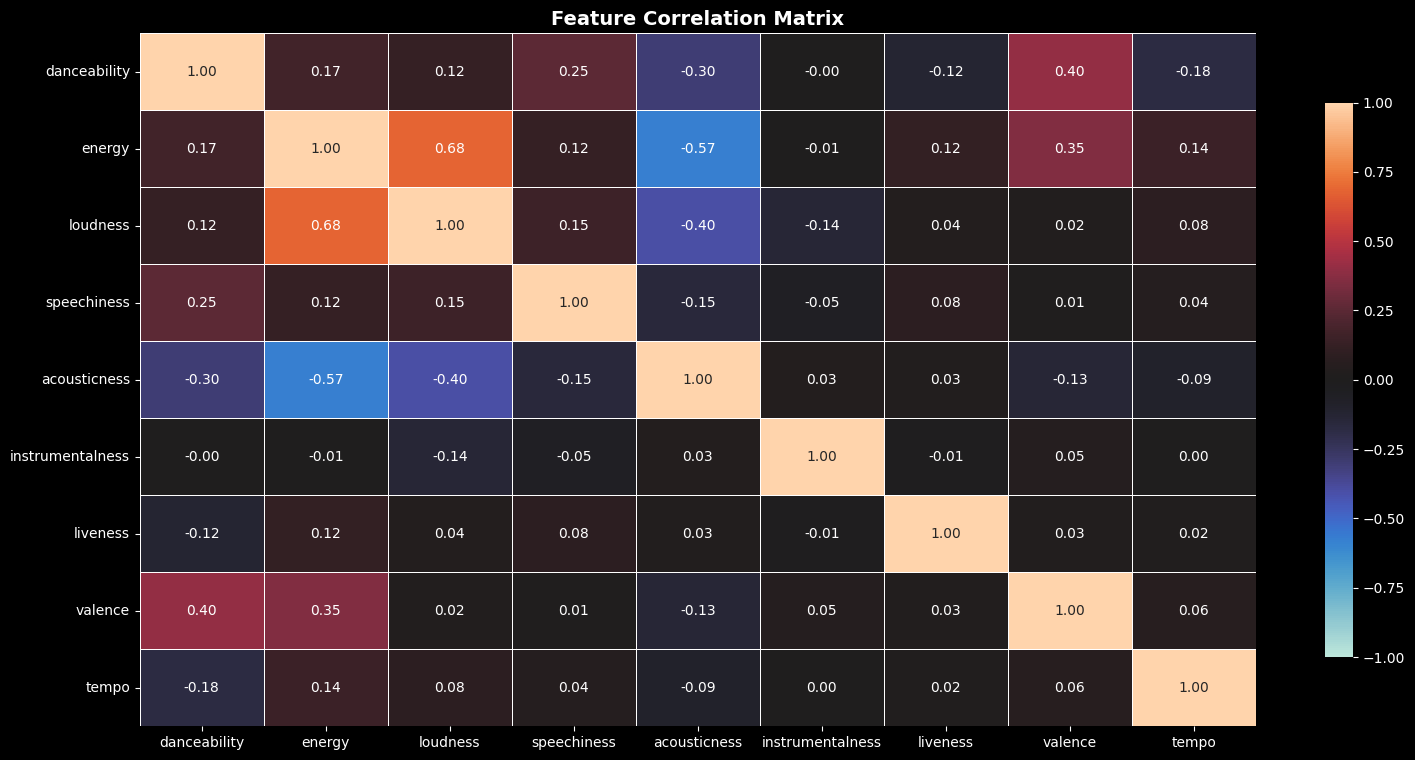

In [ ]:
# Compute correlation matrix
corr_matrix = df_clustering.corr()

# Plot heatmap
plt.figure(figsize=(18, 9))
plt.style.use("dark_background")  # Invert background for better contrast
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="icefire",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1, vmax=1,
    center=0
)

plt.title("Feature Correlation Matrix", fontsize=14, fontweight="bold", color="white")

plt.show()

In [ ]:
# Find pairs with high correlation (absolute value > 0.75)
high_corr_pairs = corr_matrix.abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] > 0.75]
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]  # Exclude self-correlation

if high_corr_pairs.empty:
    print("No highly correlated features found.")
else:
  print("Highly correlated feature pairs (|correlation| > 0.75):")
  print(high_corr_pairs)

No highly correlated features found.


#### Using PCA to Reduce Dimensions before Clustering

In [ ]:
# PCA
pca = PCA(n_components=len(features))
pca.fit(scaled_features)

# Find the number of components explaining at least 70% variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_70 = np.argmax(cumulative_variance >= 0.70) + 1  # +1 because index starts at 0

print(f"Number of Principal Components needed for ≥ 70% variance: {num_components_70}")

Number of Principal Components needed for ≥ 70% variance: 5


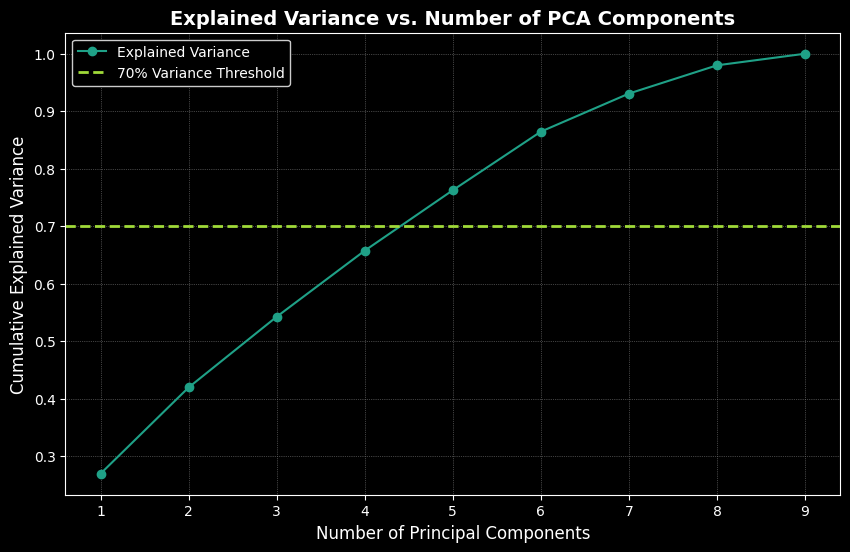

In [ ]:
# Apply PCA with optimal components
pca_optimal = PCA(n_components=num_components_70)
optimal_pca_features = pca_optimal.fit_transform(scaled_features)

colors = sns.color_palette("viridis")

plt.figure(figsize=(10,6))
plt.style.use("dark_background")
plt.plot(range(1, len(features) + 1), cumulative_variance, marker='o', linestyle='-', color=colors[3], label="Explained Variance")

# Add threshold line
plt.axhline(y=0.70, color=colors[-1], linestyle='--', linewidth=2, label="70% Variance Threshold")

# Labels and title with white text
plt.xlabel("Number of Principal Components", fontsize=12, color="white")
plt.ylabel("Cumulative Explained Variance", fontsize=12, color="white")
plt.title("Explained Variance vs. Number of PCA Components", fontsize=14, fontweight="bold", color="white")

# Grid styling for readability
plt.grid(color="gray", linestyle="dotted", linewidth=0.5)

# Legend with dark background
plt.legend(facecolor="black", framealpha=1, fontsize=10)

# Show plot
plt.show()

#### Clustering

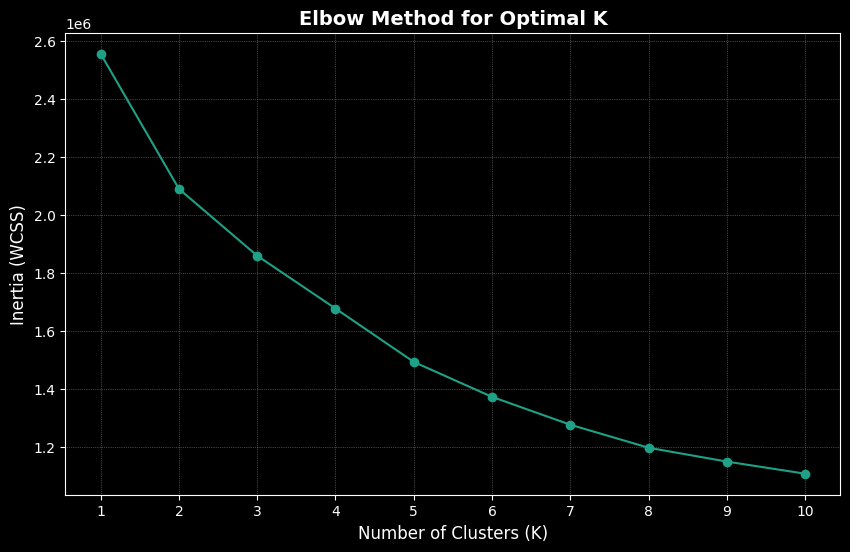

In [ ]:
# Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # kmeans.fit(optimal_pca_features)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.style.use("dark_background")
plt.plot(k_range, inertia, marker='o', linestyle='-', color=colors[3])
plt.xlabel("Number of Clusters (K)", fontsize=12, color="white")
plt.ylabel("Inertia (WCSS)", fontsize=12, color="white")
plt.title("Elbow Method for Optimal K", fontsize=14, fontweight="bold", color="white")
plt.xticks(k_range)
plt.grid(color="gray", linestyle="dotted", linewidth=0.5)
plt.show()

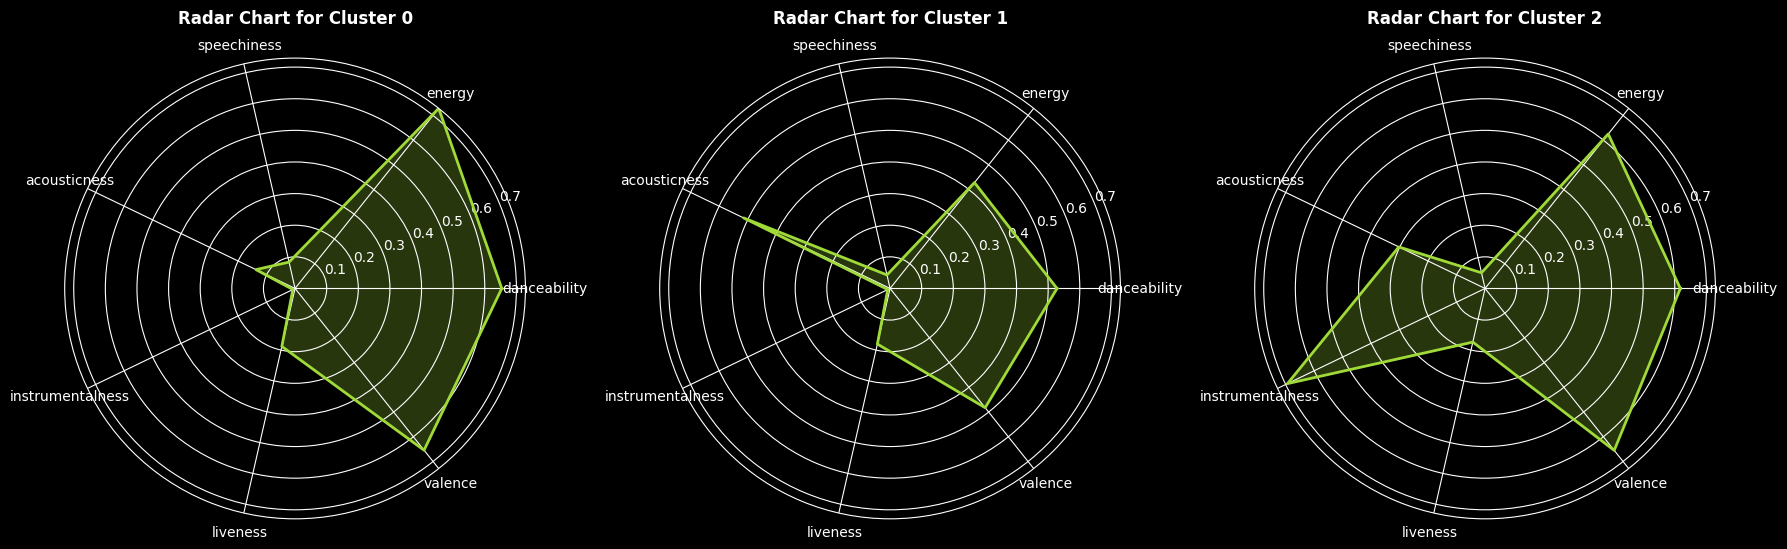

In [ ]:
kmeans_optimal = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clustering['Cluster'] = kmeans_optimal.fit_predict(scaled_features)

cluster_centers = kmeans_optimal.cluster_centers_

# Get cluster centers and transform them back to original scale
cluster_centers_scaled = scaler.inverse_transform(cluster_centers)

# Remove "tempo" and "loudness" from features
excluded_features = ["tempo", "loudness"]
selected_features = [f for f in df_clustering.columns[:-1] if f not in excluded_features]

# Get updated cluster centers without excluded features
feature_indices = [df_clustering.columns.get_loc(f) for f in selected_features]
cluster_centers_filtered = cluster_centers_scaled[:, feature_indices]

# Determine the max value across all clusters for scaling
max_values = np.max(cluster_centers_filtered, axis=0)  # Get the max per feature

# Define Rocket color palette for clusters
colors = sns.color_palette("viridis")

# Set up radar chart angles
angles = np.linspace(0, 2 * np.pi, len(selected_features), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Create separate radar charts for each cluster with same scale
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))
plt.style.use("dark_background")  # Apply dark mode

for i, ax in enumerate(axes):
    values = cluster_centers_filtered[i].tolist()
    values += values[:1]  # Close the circle

    ax.plot(angles, values, label=f'Cluster {i}', color=colors[5], linewidth=2)
    ax.fill(angles, values, alpha=0.25, color=colors[5])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(selected_features, fontsize=10, color="white")

    # Set y-axis limits based on maximum feature values
    ax.set_ylim(0, np.max(max_values))  # Standardize scale to the largest values

    ax.set_title(f"Radar Chart for Cluster {i}", pad=25, fontsize=12, fontweight="bold", color="white")

plt.tight_layout()
plt.show()

<ipython-input-60-4b60f1c3fdcf>:12: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.boxplot(x='Cluster', y='tempo', hue='Cluster', data=df_boxplot, ax=axes[0], legend=False,
<ipython-input-60-4b60f1c3fdcf>:21: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.boxplot(x='Cluster', y='loudness', hue='Cluster', data=df_boxplot, ax=axes[1], legend=False,


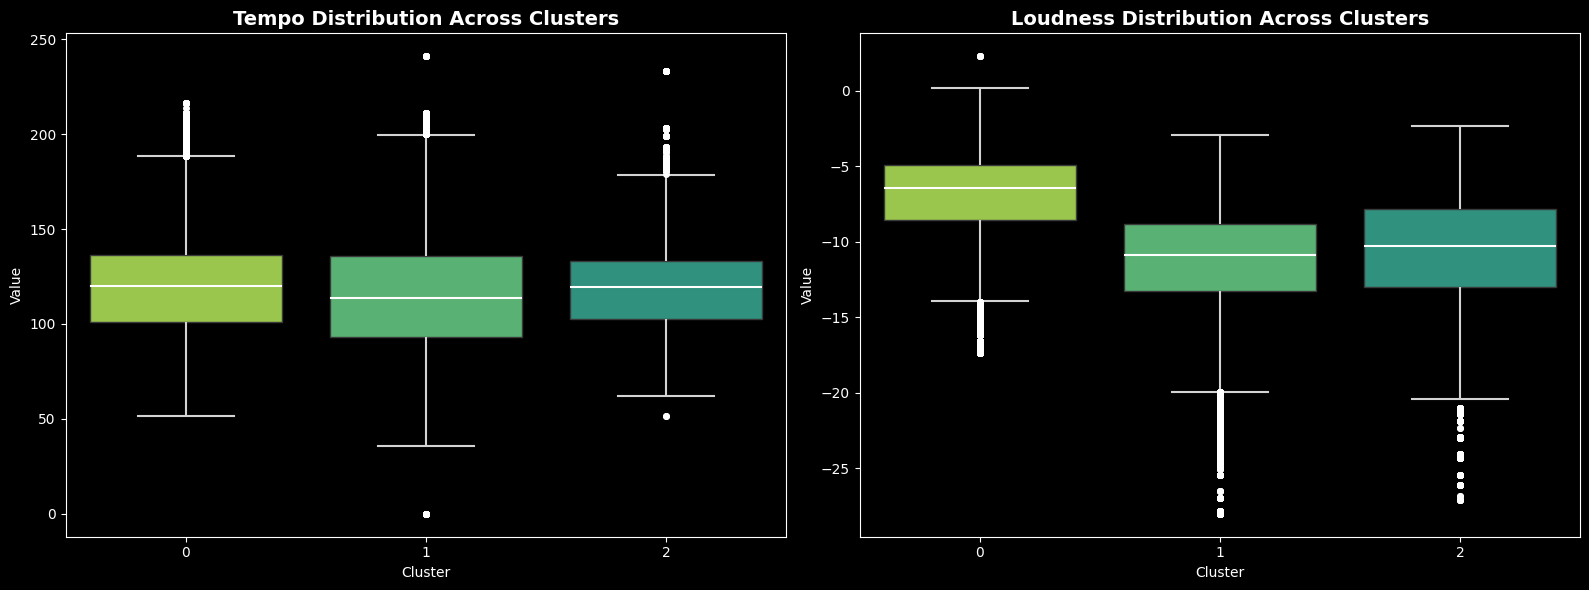

In [ ]:
plt.style.use("dark_background")

# Extract only the relevant columns along with cluster labels
df_boxplot = df_clustering[['tempo', 'loudness', 'Cluster']]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

palette = sns.color_palette("viridis_r")

# Box plot for Tempo
sns.boxplot(x='Cluster', y='tempo', hue='Cluster', data=df_boxplot, ax=axes[0], legend=False,
            palette=palette,
            whiskerprops=dict(color="lightgray", linewidth=1.5),  # Brighter whiskers
            capprops=dict(color="lightgray", linewidth=1.5),  # Brighter caps
            medianprops=dict(color="white", linewidth=1.5),  # White median line
            flierprops=dict(marker='o', mec='white', mfc='white', markersize=4))
axes[0].set_title("Tempo Distribution Across Clusters", fontsize=14, fontweight="bold")

# Box plot for Loudness
sns.boxplot(x='Cluster', y='loudness', hue='Cluster', data=df_boxplot, ax=axes[1], legend=False,
            palette=palette,
            whiskerprops=dict(color="lightgray", linewidth=1.5),  # Brighter whiskers
            capprops=dict(color="lightgray", linewidth=1.5),  # Brighter caps
            medianprops=dict(color="white", linewidth=1.5),  # White median line
            flierprops=dict(marker='o', mec='white', mfc='white', markersize=4))
axes[1].set_title("Loudness Distribution Across Clusters", fontsize=14, fontweight="bold")


# Improve readability
for ax in axes:
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()

In [ ]:
# Merge Cluster Assignments back to the original dataframe
df_clustering['Cluster'] = kmeans_optimal.labels_

df_clustering_final = df.loc[df_clustering.index, ['WeekID', 'SongID_x']].copy()
df_clustering_final['Cluster'] = kmeans_optimal.labels_

# Merge cluster labels into the original dataset
df_merged = df.merge(df_clustering_final, on=['WeekID', 'SongID_x'], how='left')

df_merged.head()

,index_x,WeekID,Week Position,Song,Performer,SongID_x,Previous Week Position,Peak Position,Weeks on Chart,spotify_genre,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,Cluster
0,68947,1966-01-01,1,The Sound Of Silence,Simon & Garfunkel,The Sound Of SilenceSimon & Garfunkel,5.0,1,7,"['classical performance', 'orchestral performa...",...,1.0,0.0301,0.8370,0.000000,0.107,0.328,106.761,4.0,76.0,1.0
1,128640,1966-01-01,2,We Can Work It Out,The Beatles,We Can Work It OutThe Beatles,11.0,2,3,"['british invasion', 'merseybeat', 'psychedeli...",...,1.0,0.0298,0.0635,0.000000,0.183,0.648,106.071,4.0,63.0,0.0
2,211865,1966-01-01,3,I Got You (I Feel Good),James Brown And The Famous Flames,I Got You (I Feel Good)James Brown And The Fam...,3.0,3,8,"['motown', 'soul']",...,1.0,0.0935,0.4120,0.000010,0.286,0.699,143.332,4.0,70.0,1.0
3,89482,1966-01-01,4,Turn! Turn! Turn! (To Everything There Is A Se...,The Byrds,Turn! Turn! Turn! (To Everything There Is A Se...,2.0,1,11,"['album rock', 'art rock', 'blues rock', 'bril...",...,1.0,0.0439,0.1350,0.000027,0.052,0.755,124.474,4.0,67.0,0.0
4,161889,1966-01-01,5,Over And Over,The Dave Clark Five,Over And OverThe Dave Clark Five,1.0,1,8,"['brill building pop', 'british invasion', 'bu...",...,1.0,0.0667,0.2450,0.000002,0.130,0.900,149.545,4.0,30.0,0.0


In [ ]:
#df_merged.to_csv('/content/drive/MyDrive/Academics/2 - Winter 2025/32024 - Algorithmic Marketing/Algorithmic Marketing Group 6/Final Project/Dataset/Clustered Songs.csv', index=False)

## Analyzing Cluster Trends

<ipython-input-15-ded9db1f4a19>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters['Cluster'] = clusters['Cluster'].astype(int)


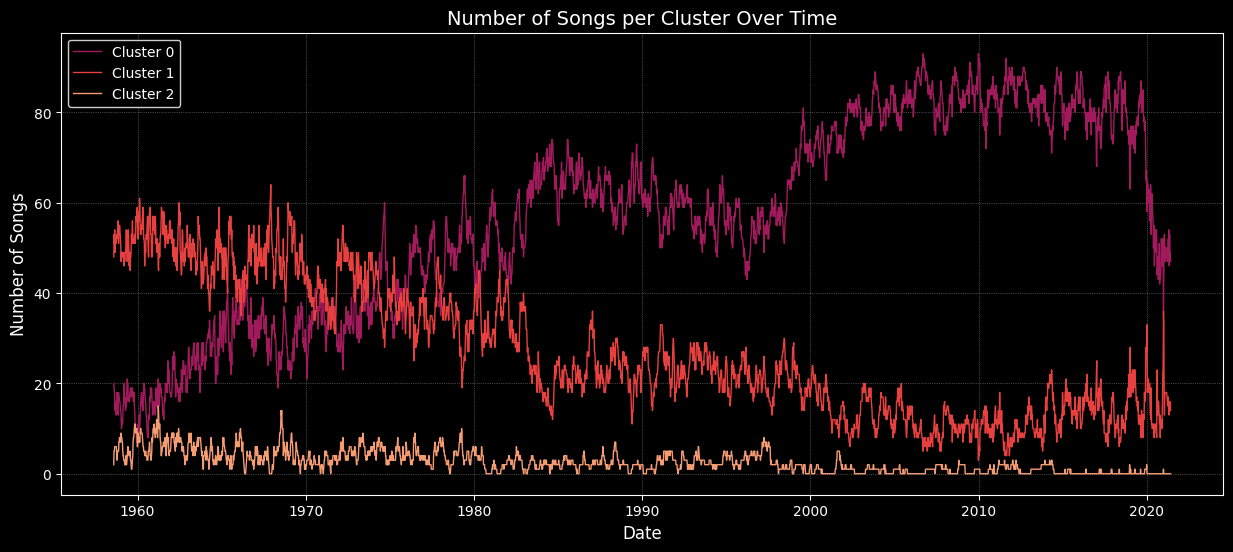

In [ ]:
clusters = df_merged.dropna(subset=['Cluster'])

clusters['Cluster'] = clusters['Cluster'].astype(int)

cluster_trend = clusters.groupby(['WeekID', 'Cluster']).size().unstack().fillna(0)

palette = sns.color_palette("rocket", n_colors=len(cluster_trend.columns)+1)
colors = palette[1:]

plt.figure(figsize=(15, 6))
plt.style.use("dark_background")

for cluster, color in zip(cluster_trend.columns, colors):
    plt.plot(cluster_trend.index, cluster_trend[cluster], label=f'Cluster {cluster}', color=color, linewidth=1)

plt.xlabel("Date", fontsize=12, color="white")
plt.ylabel("Number of Songs", fontsize=12, color="white")
plt.title("Number of Songs per Cluster Over Time", fontsize=14, color="white")
plt.legend(facecolor="black", framealpha=1, fontsize=10)
plt.grid(color="gray", linestyle="dotted", linewidth=0.5)
plt.show()

In [ ]:
df_cleaned = df_merged.dropna(subset=['Cluster'])
df_cleaned_post_2000 = df_cleaned[df_cleaned["WeekID"].dt.year >= 2000]

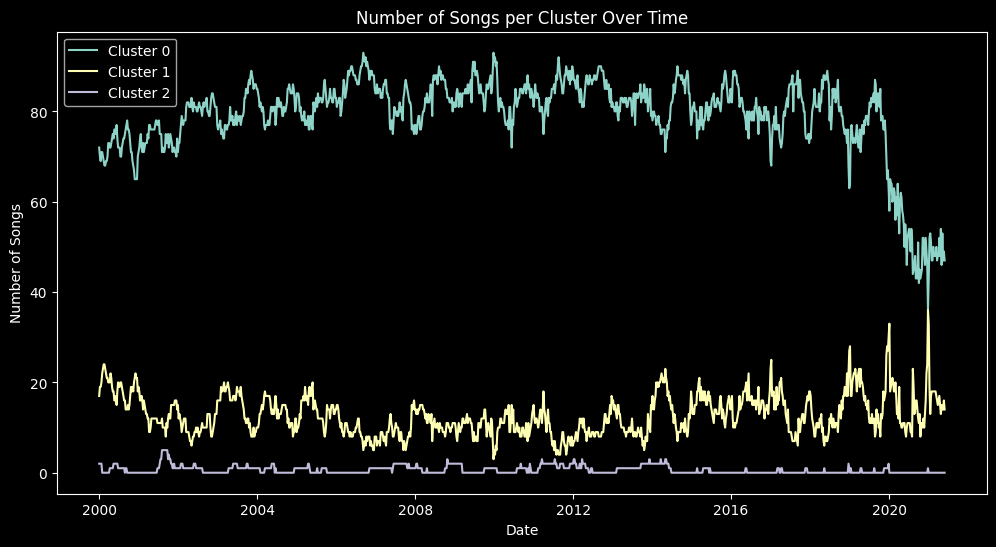

In [ ]:
# Aggregate number of songs per cluster per week
cluster_trend_post_2000 = df_cleaned_post_2000.groupby(["WeekID", "Cluster"]).size().unstack().fillna(0)

# Sort by time
cluster_trend_post_2000 = cluster_trend_post_2000.sort_index()

cluster_trend_post_2000.columns = [int(col) for col in cluster_trend_post_2000.columns]

plt.figure(figsize=(12, 6))
for cluster in cluster_trend_post_2000.columns:
    plt.plot(cluster_trend_post_2000.index, cluster_trend_post_2000[cluster], label=f'Cluster {cluster}')

plt.xlabel("Date")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Cluster Over Time")
plt.legend()
plt.show()

In [ ]:
cluster_trend_post_2000.head()

,0,1,2
WeekID,,,
2000-01-01,72.0,17.0,2.0
2000-01-08,70.0,19.0,2.0
2000-01-15,69.0,19.0,2.0
2000-01-22,71.0,20.0,2.0
2000-01-29,71.0,22.0,0.0


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Using Auto-ARIMA

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import pmdarima as pm

# Define number of splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Ensure dataset is sorted
cluster_trend_arima = cluster_trend_post_2000.fillna(0).sort_index()

# Select cluster to model (adjust for all clusters)
cluster_id = 0
errors = []

# Loop through TSCV splits
for train_idx, test_idx in tscv.split(cluster_trend_arima):
    train_data, test_data = cluster_trend_arima.iloc[train_idx], cluster_trend_arima.iloc[test_idx]

    # Train Auto-ARIMA
    auto_model = pm.auto_arima(
        train_data[cluster_id],
        seasonal=False,  # Change to True if seasonality is expected
        stepwise=True,
        suppress_warnings=True
    )

    # Forecast the test period
    predictions = auto_model.predict(n_periods=len(test_data))

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(test_data[cluster_id], predictions))
    mae = mean_absolute_error(test_data[cluster_id], predictions)
    errors.append((rmse, mae))

    print(f"Split {len(errors)} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Compute average error across all splits
avg_rmse = np.mean([e[0] for e in errors])
avg_mae = np.mean([e[1] for e in errors])

print(f"\nAuto-ARIMA Cross-Validation Results:")
print(f"Avg RMSE: {avg_rmse:.2f}, Avg MAE: {avg_mae:.2f}")

Split 1 - RMSE: 7.45, MAE: 6.42
Split 2 - RMSE: 4.53, MAE: 3.64
Split 3 - RMSE: 3.54, MAE: 2.86
Split 4 - RMSE: 7.00, MAE: 5.91
Split 5 - RMSE: 19.69, MAE: 14.58

Auto-ARIMA Cross-Validation Results:
Avg RMSE: 8.44, Avg MAE: 6.68


#### Using Hidden Markov Model

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 6.7 MB/s eta 0:00:00


In [ ]:
from hmmlearn import hmm

# Define number of states in HMM (should match meaningful patterns)
n_components = 3
errors_hmm = []

# Loop through TSCV splits
for train_idx, test_idx in tscv.split(cluster_trend_arima):
    train_data, test_data = cluster_trend_arima.iloc[train_idx], cluster_trend_arima.iloc[test_idx]

    # Train HMM model
    hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100, random_state=42)
    hmm_model.fit(train_data)

    # Predict hidden states for test period
    hidden_states = hmm_model.predict(test_data)

    # Map hidden states to expected values (use mean values per state)
    state_means = pd.DataFrame(hmm_model.means_, columns=cluster_trend_arima.columns)
    predicted_values = np.array([state_means.iloc[state] for state in hidden_states])

    # Compute RMSE and MAE
    rmse_hmm = np.sqrt(mean_squared_error(test_data[cluster_id], predicted_values[:, cluster_id]))
    mae_hmm = mean_absolute_error(test_data[cluster_id], predicted_values[:, cluster_id])
    errors_hmm.append((rmse_hmm, mae_hmm))

    print(f"Split {len(errors_hmm)} - RMSE: {rmse_hmm:.2f}, MAE: {mae_hmm:.2f}")

# Compute average errors
avg_rmse_hmm = np.mean([e[0] for e in errors_hmm])
avg_mae_hmm = np.mean([e[1] for e in errors_hmm])

print(f"\nHMM Cross-Validation Results:")
print(f"Avg RMSE: {avg_rmse_hmm:.2f}, Avg MAE: {avg_mae_hmm:.2f}")

Split 1 - RMSE: 6.83, MAE: 6.21
Split 2 - RMSE: 3.09, MAE: 2.48
Split 3 - RMSE: 3.18, MAE: 2.58
Split 4 - RMSE: 3.47, MAE: 2.94
Split 5 - RMSE: 17.14, MAE: 12.11

HMM Cross-Validation Results:
Avg RMSE: 6.74, Avg MAE: 5.26


Based on the Cross-Validation Results, Hiddne Markov Models performed better, and are selected for our forecasting. But first, we try to find the best amount of states for our model.

In [ ]:
# Select a cluster to model (loop through all clusters later if needed)
cluster_id = 0

# Convert data into HMM-compatible format
df_model = cluster_trend_post_2000[[cluster_id]].reset_index()
df_model.columns = ["date", "y"]

In [ ]:
# Define range of `n_components` to test
n_components_range = [2, 3, 4, 5]

# Store models and log-likelihoods
hmm_models = {}
log_likelihoods = {}

# Train HMM with different `n_components`
for n in n_components_range:
    hmm_model = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, random_state=42)
    hmm_model.fit(df_model[["y"]])  # Train the model

    # Store model and log likelihood
    hmm_models[n] = hmm_model
    log_likelihoods[n] = hmm_model.score(df_model[["y"]])  # Model fit score

# Convert results to a DataFrame for easy comparison
log_likelihood_df = pd.DataFrame.from_dict(log_likelihoods, orient="index", columns=["Log Likelihood"])
log_likelihood_df.index.name = "n_components"

# Display log-likelihood values
print("\nHMM Log Likelihoods for Different n_components:")
print(log_likelihood_df)

# Select the best `n_components` based on highest log-likelihood
best_n_components = max(log_likelihoods, key=log_likelihoods.get)
best_hmm_model = hmm_models[best_n_components]

# Print the best `n_components`
print(f"\nBest number of hidden states (n_components) based on log-likelihood: {best_n_components}")


HMM Log Likelihoods for Different n_components:
              Log Likelihood
n_components                
2               -3385.264995
3               -3385.256467
4               -2775.237572
5               -2776.260031

Best number of hidden states (n_components) based on log-likelihood: 4


In [ ]:
# Extract the learned transition matrix
transition_matrix = pd.DataFrame(
    best_hmm_model.transmat_,
    columns=[f"State {i+1}" for i in range(best_n_components)],
    index=[f"State {i+1}" for i in range(best_n_components)]
)

# Extract emission means (Expected song count per state)
emission_means = pd.DataFrame(best_hmm_model.means_, columns=["Expected Song Count"])

# Extract start probabilities (Initial probabilities of each state)
start_probabilities = pd.DataFrame(
    best_hmm_model.startprob_, columns=["Probability"],
    index=[f"State {i+1}" for i in range(best_n_components)]
)

# Display matrices
print("\nHMM Transition Matrix:")
print(transition_matrix)

print("\nHMM Emission Means (Expected Song Count per State):")
print(emission_means)

print("\nHMM Start Probabilities:")
print(start_probabilities)


HMM Transition Matrix:
               State 1        State 2       State 3        State 4
State 1   9.764283e-01  3.837215e-175  2.357171e-02  5.763438e-140
State 2  1.276981e-165   9.340696e-01  7.836338e-11   6.593040e-02
State 3   9.247036e-03   4.824854e-20  9.406177e-01   5.013525e-02
State 4  4.611714e-160   4.720238e-02  3.977247e-02   9.130251e-01

HMM Emission Means (Expected Song Count per State):
   Expected Song Count
0            53.524358
1            86.859088
2            75.703457
3            81.794751

HMM Start Probabilities:
          Probability
State 1  5.398796e-79
State 2  0.000000e+00
State 3  1.000000e+00
State 4  0.000000e+00


In [ ]:
hmm_model = hmm.GaussianHMM(n_components=best_n_components, covariance_type="diag", n_iter=100, random_state=42)
hmm_model.fit(df_model[["y"]])

GaussianHMM(n_components=4, n_iter=100, random_state=42)

In [ ]:
# Define forecast period
n_forecast = 20
n_simulations = 100  # Number of Monte Carlo simulations

# Use the last observed state as the starting point
last_observed_state = hmm_model.predict(df_model[["y"]])[-1]

# Store multiple simulation paths
simulated_forecasts = []

for _ in range(n_simulations):
    future_states = []
    current_state = last_observed_state

    for _ in range(n_forecast):
        # Sample next state based on probabilities
        next_state = np.random.choice(range(hmm_model.n_components), p=hmm_model.transmat_[current_state])
        future_states.append(next_state)
        current_state = next_state

    simulated_forecasts.append(future_states)  # Store the sequence of states

# Map states to expected song counts
state_means = pd.DataFrame(hmm_model.means_, columns=["y"])
forecast_hmm = np.mean(
    np.array([[state_means.iloc[state] for state in states] for states in simulated_forecasts]),
    axis=0
)

# Adjust the first forecast value to align with the last observed value
forecast_hmm[0] = df_model["y"].iloc[-1]  # Set first forecast to last actual value
forecast_hmm = forecast_hmm.reshape(-1)
forecast_hmm = np.concatenate([[df_model["y"].iloc[-1]], forecast_hmm[1:]])

# Generate future dates
future_dates = pd.date_range(df_model["date"].iloc[-1], periods=n_forecast+1, freq="W")[1:]

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({"date": future_dates, "forecast": forecast_hmm})

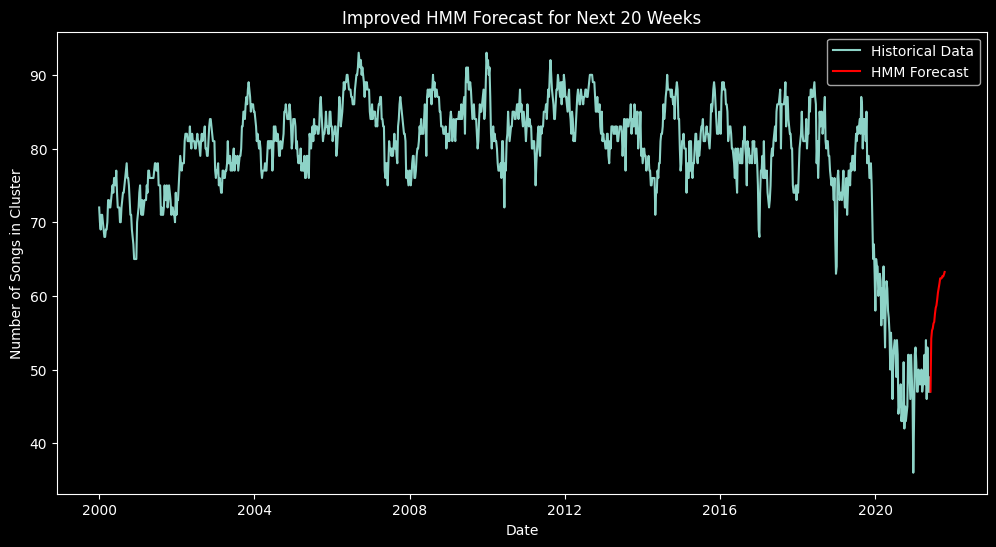

In [ ]:
# Plot the improved HMM Forecast
plt.figure(figsize=(12, 6))
plt.plot(df_model["date"], df_model["y"], label="Historical Data", linestyle="solid")
plt.plot(forecast_df["date"], forecast_df["forecast"], label="HMM Forecast", linestyle="solid", color="red")
plt.xlabel("Date")
plt.ylabel("Number of Songs in Cluster")
plt.title("Improved HMM Forecast for Next 20 Weeks")
plt.legend()
plt.show()

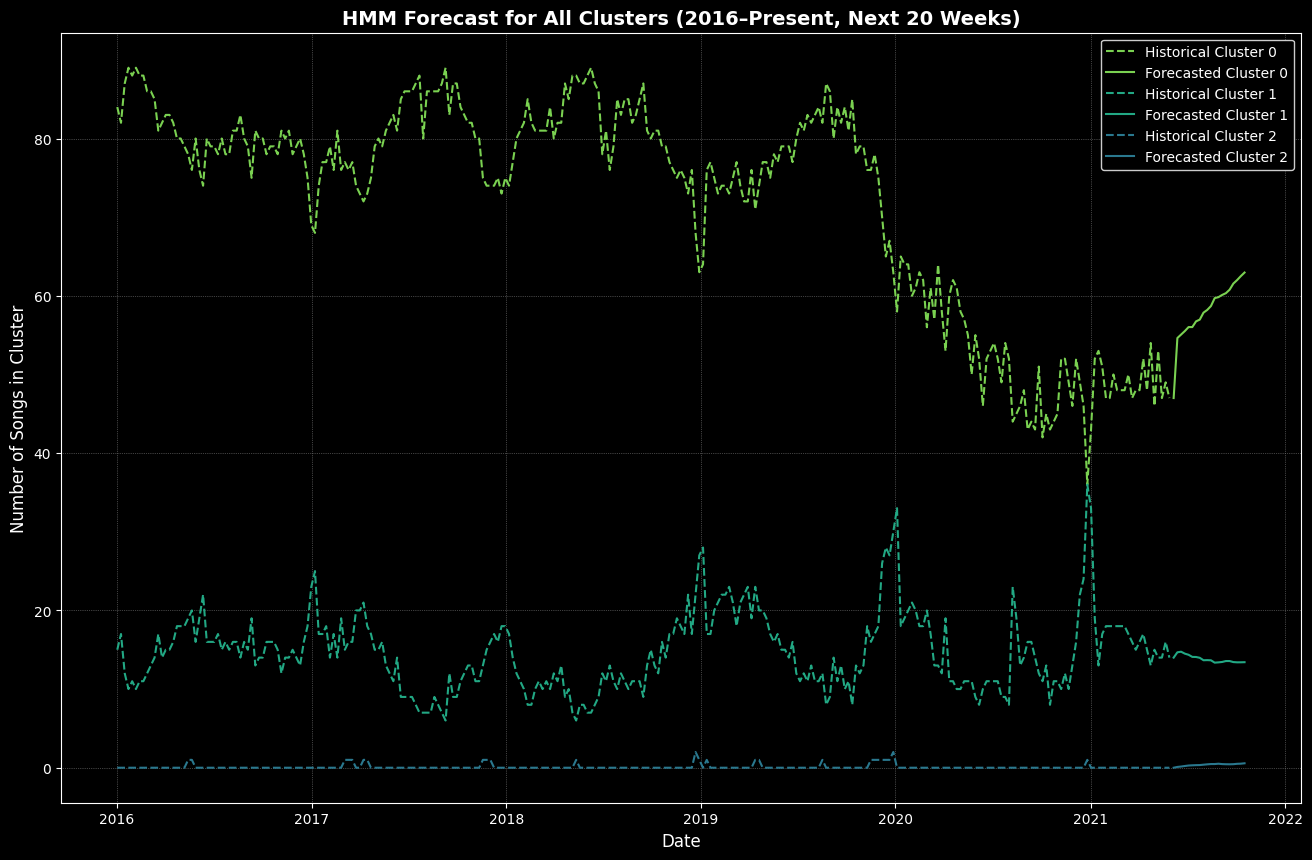

In [ ]:
palette = sns.color_palette("viridis_r", n_colors=len(cluster_trend_post_2000.columns)+1)
colors = palette
plt.style.use("dark_background")
plt.figure(figsize=(16, 10))

for cluster_id, color in zip(cluster_trend_post_2000.columns, colors):
    # Prepare cluster data
    df_model = cluster_trend_post_2000[[cluster_id]].reset_index()
    df_model.columns = ["date", "y"]

    # Train HMM model
    hmm_model = hmm.GaussianHMM(n_components=best_n_components, covariance_type="diag", n_iter=100, random_state=42)
    hmm_model.fit(df_model[["y"]])

    # Use last observed state for forecasting
    last_observed_state = hmm_model.predict(df_model[["y"]])[-1]

    # Store multiple simulation paths
    simulated_forecasts = []

    for _ in range(n_simulations):
        future_states = []
        current_state = last_observed_state

        for _ in range(n_forecast):
            # Sample next state using transition matrix
            next_state = np.random.choice(range(hmm_model.n_components), p=hmm_model.transmat_[current_state])
            future_states.append(next_state)
            current_state = next_state

        simulated_forecasts.append(future_states)

    # Convert states to expected song counts
    state_means = pd.DataFrame(hmm_model.means_, columns=["y"])
    forecast_hmm = np.mean(
        np.array([[state_means.iloc[state] for state in states] for states in simulated_forecasts]),
        axis=0
    )

    # Smooth transition from historical to forecasted values
    forecast_hmm[0] = df_model["y"].iloc[-1]
    forecast_hmm = forecast_hmm.reshape(-1)
    forecast_hmm = np.concatenate([[df_model["y"].iloc[-1]], forecast_hmm[1:]])

    # Generate future dates
    future_dates = pd.date_range(df_model["date"].iloc[-1], periods=n_forecast+1, freq="W")[1:]

    # Convert forecast to DataFrame
    forecast_df = pd.DataFrame({"date": future_dates, "forecast": forecast_hmm})

    # Filter historical data from 2016 onwards for visualization purposes
    df_model_filtered = df_model[df_model["date"] >= "2016-01-01"]

    # Plot historical data (dashed lines) from 2016 onwards
    plt.plot(df_model_filtered["date"], df_model_filtered["y"], label=f"Historical Cluster {cluster_id}", linestyle="dashed", color=color)

    # Plot forecast data (solid lines)
    plt.plot(forecast_df["date"], forecast_df["forecast"], label=f"Forecasted Cluster {cluster_id}", linestyle="solid", color=color)

# Finalize plot
plt.xlabel("Date", fontsize=12, color="white")
plt.ylabel("Number of Songs in Cluster", fontsize=12, color="white")
plt.title("HMM Forecast for All Clusters (2016–Present, Next 20 Weeks)", fontsize=14, fontweight="bold", color="white")
plt.legend(facecolor="black", framealpha=1, fontsize=10)
plt.grid(color="gray", linestyle="dotted", linewidth=0.5)
plt.show()